# About
- goal is to include a functional response to modify the energy intake parameter $a$ over time
- may possible also modify the exponent of the energy terms as it has been shown to stray away from $\frac{3}{4}$ ($am^\frac{3}{4}$) under non-ideal conditions by Samraat's dimenstionality paper.

aim for: 
- $$\frac{dm}{dt} = F_ram^\frac{3}{4} - bm - cm^\rho 
\text{ -->Where: } F_r = \text{Functional Response}$$

ABOVE IS A MISUNDERSTANDING BY ME

acutally need to modify the whole $am^\frac{3}{4}$ term, where the exponent will scale like Samraat's dimensionality paper.

# Equations
## Mass
- $\alpha$ = age of maturity
- $m_\alpha$ = size at maturity
- $a$ = growth rate
- $b$ = maintenace cost per cell
- $c$ = reproduction cost per cell
<p>&nbsp;</p>

Before reproduction is factored in:
<p>&nbsp;</p> 
\begin{align}
        \frac{dm}{dt} &= am^\frac{3}{4} - bm  &m < m_\alpha \\
        \frac{dm}{dt} &= am^\frac{3}{4} - bm - cm^\rho  &m > m_\alpha \\
\end{align}

## Reproduction
##### Base Equation 
##### Variable Meanings
- $R_0$ = Lifetime production of offspring
- $cm$ = Reproductive allocation
- $m$ =  mass
- $\rho$ = reproductive scaling
- $h(t)$ = efficiency term representing a declining efficiency , i.e. reproductive senesence.
- $l_t$ = Probability of survival
- $L_t / L_\alpha$ = scaling factor for mature population
- $\alpha$ = feasible ages of first breeding 
- $b_t$ = effective energy allocated to reproduction
\begin{align}
    R_0 &= \int_\alpha^\infty l_t b_t dt\\
    R_0 &= \int_\alpha^\infty cm^\rho h_tl_tdt\\
\end{align}

##### Derived Equation
##### Variable Meanings
- $L_\alpha$ = Mortality before maturity
- $Z$ = Adult instantaneous mortality rate (m > $m_\alpha$)
- $\kappa$ = rate parameter, controles reproductive senesence rate
- $Z(t)$ = instantaneous mortality rate at age t
\begin{align}
    R_0 &= \int_\alpha^\infty cm^\rho h_tl_tdt\\
    &= \int_\alpha^\infty cm^\rho (t)^\rho e^{-\kappa(t-\alpha)} L_\alpha e^{Z(t-\alpha)}dt\\
    &= L_\alpha \int_\alpha^\infty cm^\rho (t)^\rho e^{-\kappa(t-\alpha)} e^{Z(t-\alpha)}dt\\
        &= cL_\alpha \int_\alpha^\infty m^\rho (t)^\rho e^{-(\kappa Z)(t-\alpha)}dt\\
    &= c\int_0^\alpha e^{-Z(t)} dt  \int_\alpha^\infty m(t)^\rho e^{-(\kappa +Z)(t-\alpha)}dt\\
\end{align}


$$
\text{Cumulative Reproduction} = \\
\int_0^\alpha \text{juvenile mortality  } dt \int_\alpha^\infty \text{reproductive cost}^\rho \times\text{mortality } dt\\
\frac{dm}{dt} = \text{energy supply} - \text{maintance cost} - \text{reproductive cost}^\rho
$$

# Functional Response
- $a$ = attack rate
- $h$ = handling time
- $X_r$ = Resource Density
- $q$ = dimensionless exponent that transitions between full Type II ($q = 0$) and Full Type III($q = 1$) response
\begin{align}
    \frac{a X_r^{q+1}}{1 + h a X_r^{q+1}}
\end{align}

## Concerns with Implimentation
- how to define the range of the response
- how do things really fluctuate with time
- where to fluctuate around (around maximum ingestion rate (1/h)? by how much to fluctuate)
- can it be used when part of a is to do with resting metabolic rate?
- how to define the parameters (a, h in a general manner?

# Functions

## Functional Response
- A functional response to be included with the energy intake parameters

In [1]:
def FuncResp(Xr, a, h, q = 0):
    
    """
    The equation for the more general Type II functional response curve.
    Need an argument params which is a dictionary containing the parameter values.
    This dictionary is made using lmfit.parameters().
    Includes a dimensionless parameter `q` which is used to account for a small lag phase at 
    the start of the curve and is a type III response at q = 1.

    Arguments:
        a {float} -- Attack rate
        h {float} -- handling time
        q {float} -- dimensionless exponent
        Xr {float} -- Resource Density
        data {float} -- the data that Xr is compared against if minimising the difference 
                        using lmfit.minimize()
    
    Returns:
        {float} -- Consumption rate
    """
    top = a * (Xr ** (q + 1))
    bot = 1 + (h * a * (Xr ** (q + 1)))
    C = top / bot
    return C

## Lifetime Reproduction and Mass

In [2]:
import scipy as sc
from scipy import exp
from scipy import integrate
from math import floor
import matplotlib.pyplot as plt



def L(t, k = 0.01):
    """
        Calculates lifetime reproductive output of an organism, 
        as described in Charnov et al. 2001.

        Arguments:
            t {int} -- time
            k {float} -- reproduction senescence
        Returns:
            {float} -- lifetime reproductive output
    """
    return exp(-k*t)
def dRmdt(mR0, t, alpha = 50, M = 1000, a = 2.15, c = 0.17, rho = 0.06, k = 0.01, seasonal = True): 
    """
    A function to simulate change in mass and reproductive output for a time point.  
    Function designed with the intention of beign integrated.
    
        Arguments:
        t {float} -- time
        mR0 {float} -- array with mass (g) and reproduction at start of time step 
        alpha {float} -- asymtotic mass (g)
        M {float} -- asymptotic mass
        a {float} -- growth rate (UNITS?)
        b {float} -- maintenace cost per cell ## found in function
        c {float} -- reproductive cost (UNITS?)}
        rho {float} -- scaling factor of reproduction (UNITS?)
        k
        Z {float} -- ## found in function
        
    Returns:
        {dict} -- 
            dmdt --rate of change of mass in grams^1/4 per day (g^1/4 d^-1) at time t
                NOTE:  integration of dmdt will give mass at t
            Rt -- reproductive output at time t in terms of mass 
                NOTE: integration of Rt gives total Reproductive output for the bounds of the integral
    """
    # predefine outputs 
                
    m = mR0[0] 
    R = mR0[1]
    b = a/(M**0.25)
    Z = 2/alpha
    Q = L(t-alpha, k)
    
    # seasonality
    # turn t into an option to vary supply
    # adjust `t` if over 1 year to within one year
    if t > 365:
        t_temp = t - (365 * floor(t/365))
    else:
        t_temp = t
    x = t_temp/365 # as a percentage of the year to mimic a full year of seasonality
    # recalculate `a` with seasonality
    #-->(renamed to avoid futher changing the value for further integration iteratons)
    # not using functional response 
#-->and just scaling `a` over time with average of 0.5
#     a_temp = (0.75*a) +(0.25*sc.sin(x)) # vary around from 50 - 100% of `a` with mean 75% a * (0.75+(0.25*sc.sin(x)))
# using functional response
# `a` thought of as the max possible value for Xr and vary around that
    a_temp = FuncResp(Xr = a * (1+(0.5*sc.sin(x))), a = 4, h = 1/a, q = 0)
    if seasonal == False:
        a_temp = a
    
    # conditional tree dependant on `alpha` 
    if t < 0:
        return "ERROR: time < 0"
    if t < alpha:
        dmdt = (a_temp * (m**0.75)) - (b * m)
        R = 0
    elif t >= alpha:
        dmdt = (a_temp * (m**0.75)) - (b * m) - (c * (m**rho))
#         R = Q*c * m**rho
        R = (c * m**rho) * exp(-(k + Z) * (t - alpha))
    if m + dmdt < 0: # still not 100% sure why `-m`
        dmdt = -m
    
    return sc.array([dmdt, R])
#     return dict["dmdt" : dmdt, "Reproduciton" : R]


# Implimentation (Single values)

## Code

In [29]:
## imports
import scipy as sc
from scipy import integrate

days = 8000#1500 #  time to simulate over

# define starting parameters -- using cod values from west 2001 as a base/ballpark values

m0 = 0.1 # starting mass at t_0
R0 = 0 # starting reproduction at t_0, 0 because organism not yet mature in my sims
# a = 0.017#2.15 # cost of new mass 
a = 2.15
b =  0 # no need to calculate right now since i do it in function,could be done here to save time
c = 0.017

# reproductive cost 
M =  25000
alpha = 1000 # age of maturation (days)
# rho = 0.68#0.23 # reproductive scaling parameter
rho = 0.23
k =  0.01

# function options
seasonal = True
# organising starting params for use

mR0 = sc.array([m0, R0]) # starting values for integration, [starting mass, starting repro]
t = sc.arange(0, days, 1) # t values for integration
params = (alpha, M, a, c, rho, k, seasonal) # tuple for integration arguments


# integration
mR = integrate.odeint(dRmdt, mR0, t, args = params)
mass = mR[:, 0]
repro = mR[:, 1]

# comaprison - non-seasonal
mRSeason = integrate.odeint(dRmdt, mR0, t, args = (alpha, M, a, c, rho, k, False))
massSeason = mRSeason[:, 0]
reproSeason = mRSeason[:, 1]
# exploring output
# mass[-1000:-675] # final 50 values to check for `nan`




In [30]:
# exploration of data
print(max(repro))
print(max(reproSeason))
# reproSeason[1400:1500]

12.3474657564
14.5472573285


## Plots

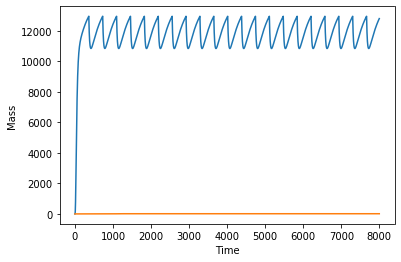

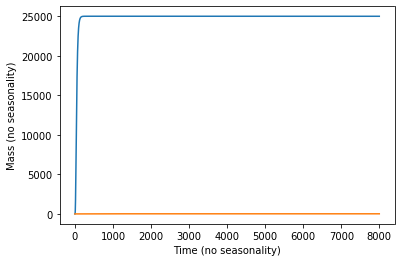

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t, mass)
plt.plot(t, repro)
plt.xlabel("Time")
plt.ylabel("Mass")
plt.show()
plt.figure()
plt.plot(t, massSeason)
plt.plot(t, reproSeason)
plt.xlabel("Time (no seasonality)")
plt.ylabel("Mass (no seasonality)")
plt.show()

# Exploring $\rho$ Values
- looking at what values `sc.integrate.odeint` can handle
- looking at how behaviour of the model changes with just changes in $\rho$

## Code

In [24]:
## imports
import scipy as sc
from scipy import integrate

days = 1500 # time to simulate over

# define starting parameters -- using cod values from west 2001 as a base/ballpark values

m0 = 0.1 # starting mass at t_0
R0 = 0 # starting reproduction at t_0, 0 because organism not yet mature in my sims
a = 0.017 # cost of new mass 
b = 0 ## no need to calculate right now since i do it in function,could be done here to save time
c = 0.017 # reproductive cost 
M = 25000
alpha = 700 # age of maturation (days)
rho = .687 # reproductive scaling parameter | placeholder for this exploration
k = 0.01

# define rho values to interate over
rhoVals = sc.linspace(0, 2, 20)

# define vars to hold the output for each rho value
mass = dict()
repro = dict()



# organising starting params for use

mR0 = sc.array([m0, R0]) # starting values for integration, [starting mass, starting repro]
t = sc.arange(0, days, 1) # t values for integration
params = (alpha, M, a, c, rho, k) # tuple for integration arguments |need to specify in loop because of changig values


# integration
for rho in rhoVals:
    mR = integrate.odeint(dRmdt, mR0, t, args = (alpha, M, a, c, rho, k))
    mass[str(rho)] = mR[:, 0]
    repro[str(rho)] = mR[:, 1]

# exploring output
print(mass.keys())
mass["2.0"][-50:]



dict_keys(['0.0', '0.105263157895', '0.210526315789', '0.315789473684', '0.421052631579', '0.526315789474', '0.631578947368', '0.736842105263', '0.842105263158', '0.947368421053', '1.05263157895', '1.15789473684', '1.26315789474', '1.36842105263', '1.47368421053', '1.57894736842', '1.68421052632', '1.78947368421', '1.89473684211', '2.0'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in double_scalars


array([ 0.81060288,  0.81067647,  0.81074978,  0.81082282,  0.81089558,
        0.81096806,  0.81104026,  0.81111218,  0.81118382,  0.81125519,
        0.81132627,  0.81067283,  0.8100343 ,  0.80941038,  0.80880079,
        0.80820524,  0.80762347,  0.8070552 ,  0.80650016,  0.80595811,
        0.80542879,  0.80491195,  0.80440735,  0.80391476,  0.80343394,
        0.80296466,  0.80250671,  0.80205987,  0.80162392,  0.80119866,
        0.80078387,  0.80037938,  0.79998496,  0.79960044,  0.79922563,
        0.79886034,  0.79850439,  0.79815761,  0.79781981,  0.79749084,
        0.79717052,  0.7968587 ,  0.7965552 ,  0.79625988,  0.79597258,
        0.79569315,  0.79542145,  0.79515732,  0.79490062,  0.79465122])

## Plots

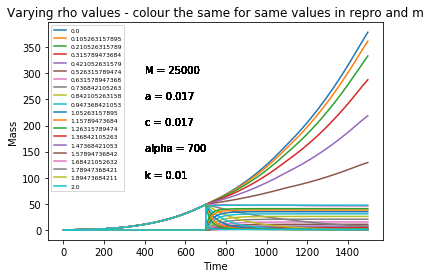

In [25]:
plt.figure()
ax = plt.gca()
# extra details to include in the graph as text
M_annotation  = "M = " + str(M)
a_annotation  = "a = " + str(a)
c_annotation  = "c = " + str(c)
alpha_annotation  = "alpha = " + str(alpha)
k_annotation  = "k = " + str(k)
for i in mass.keys():
    # keep color the same for both growth curve and repro curve with same rho value
    color = next(ax._get_lines.prop_cycler)['color'] 
    plt.plot(t, mass[i], color = color, label = i)
    plt.plot(t, repro[i], color = color)
    # label for each value to be use in the legend
    plt.legend(loc = "upper left", prop={'size': 6})
    # formatting
    plt.xlabel("Time")
    plt.ylabel("Mass")
    plt.title("Varying rho values - colour the same for same values in repro and m")
    # extra details for graph
    plt.text(400, 300, M_annotation) 
    plt.text(400, 250, a_annotation) 
    plt.text(400, 200, c_annotation) 
    plt.text(400, 150, alpha_annotation) 
    plt.text(400, 100, k_annotation)
# save image
plt.savefig("../results/rhoFunc_exploration.png", dpi = 200)


## Notes:
- `nan` values start to appear around $\rho = 0.7$ and on in both mass and reproduction

# Exploring $\alpha$ Values

## Code

In [8]:
## imports
import scipy as sc
from scipy import integrate

days = 1500 # time to simulate over

# define starting parameters -- using cod values from west 2001 as a base/ballpark values

m0 = 0.1 # starting mass at t_0
R0 = 0 # starting reproduction at t_0, 0 because organism not yet mature in my sims
a = 0.017 # cost of new mass 
b = 0 ## no need to calculate right now since i do it in function,could be done here to save time
c = 0.017 # reproductive cost 
M = 25000
alpha = 700 # age of maturation (days) | placeholder for this exploration
rho = .687 # reproductive scaling parameter 
k = 0.01

# define rho values to interate over
alphaVals = sc.linspace(0, 1000, 20) # values every 50

# define vars to hold the output for each rho value
mass = dict()
repro = dict()



# organising starting params for use

mR0 = sc.array([m0, R0]) # starting values for integration, [starting mass, starting repro]
t = sc.arange(0, days, 1) # t values for integration
params = (alpha, M, a, c, rho, k) # tuple for integration arguments |need to specify in loop because of changig values


# integration
for alpha in alphaVals:
    mR = integrate.odeint(dRmdt, mR0, t, args = (alpha, M, a, c, rho, k))
    mass[str(alpha)] = mR[:, 0]
    repro[str(alpha)] = mR[:, 1]

# exploring output
mass["789.473684211"][600:800]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars


array([ 31.40693384,  31.55388143,  31.70131994,  31.84925025,
        31.99767322,  32.14658972,  32.29600062,  32.44590677,
        32.59630904,  32.74720829,  32.89860539,  33.05050119,
        33.20289656,  33.35579236,  33.50918944,  33.66308867,
        33.8174909 ,  33.97239698,  34.12780778,  34.28372414,
        34.44014692,  34.59707698,  34.75451517,  34.91246233,
        35.07091931,  35.22988698,  35.38936616,  35.54935773,
        35.70986251,  35.87088135,  36.03241511,  36.19446462,
        36.35703074,  36.52011429,  36.68371612,  36.84783707,
        37.01247799,  37.17763971,  37.34332307,  37.5095289 ,
        37.67625804,  37.84351132,  38.01128959,  38.17959367,
        38.34842439,  38.51778259,  38.68766909,  38.85808473,
        39.02903032,  39.20050671,  39.37251471,  39.54505515,
        39.71812886,  39.89173665,  40.06587934,  40.24055777,
        40.41577276,  40.59152511,  40.76781565,  40.94464519,
        41.12201455,  41.29992455,  41.478376  ,  41.65

## Plots

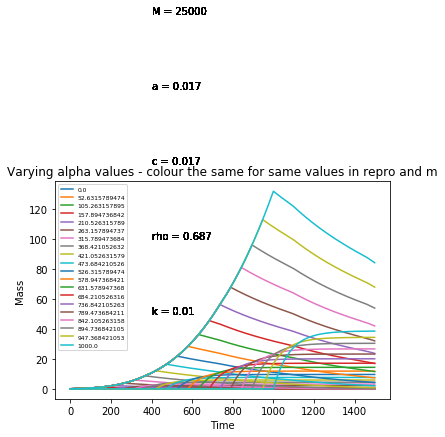

In [9]:
plt.figure()
ax = plt.gca()
# extra details to include in the graph as text
M_annotation  = "M = " + str(M)
a_annotation  = "a = " + str(a)
c_annotation  = "c = " + str(c)
rho_annotation  = "rho = " + str(rho)
k_annotation  = "k = " + str(k)

for i in mass.keys():
    # keep color the same for both growth curve and repro curve with same rho value
    color = next(ax._get_lines.prop_cycler)['color'] 
    plt.plot(t, mass[i], color = color, label = i)
    plt.plot(t, repro[i], color = color)
    # label for each value to be use in the legend
    plt.legend(loc = "upper left", prop={'size': 6})
    # formatting
    plt.xlabel("Time")
    plt.ylabel("Mass")
    plt.title("Varying alpha values - colour the same for same values in repro and m")
    # extra details for graph
    plt.text(400, 250, M_annotation) 
    plt.text(400, 200, a_annotation) 
    plt.text(400, 150, c_annotation) 
    plt.text(400, 100, rho_annotation) 
    plt.text(400, 50, k_annotation)
# save image
plt.savefig("../results/alphaFunc_exploration.png", dpi = 200)

## Notes
- `nan` not produced - range(0 -1000)
- seems that if `nan` is produced an increase in $\alpha$ alleviates the problem.  
    - i.e. it does play a role in what is causing `nan` production

# Exploring $c$ Values

## Code

In [10]:
## imports
import scipy as sc
from scipy import integrate

days = 1500 # time to simulate over

# define starting parameters -- using cod values from west 2001 as a base/ballpark values

m0 = 0.1 # starting mass at t_0
R0 = 0 # starting reproduction at t_0, 0 because organism not yet mature in my sims
a = 0.017 # cost of new mass 
b = 0 ## no need to calculate right now since i do it in function,could be done here to save time
c = 0.017 # reproductive cost 
M = 25000
alpha = 700 # age of maturation (days) | placeholder for this exploration
rho = .687 # reproductive scaling parameter 
k = 0.01

# define rho values to interate over
c_Vals = sc.linspace(0, 0.4, 40) 

# define vars to hold the output for each rho value
mass = dict()
repro = dict()



# organising starting params for use

mR0 = sc.array([m0, R0]) # starting values for integration, [starting mass, starting repro]
t = sc.arange(0, days, 1) # t values for integration
params = (alpha, M, a, c, rho, k) # tuple for integration arguments |need to specify in loop because of changig values


# integration
for c in c_Vals:
    mR = integrate.odeint(dRmdt, mR0, t, args = (alpha, M, a, c, rho, k))
    mass[str(c)] = mR[:, 0]
    repro[str(c)] = mR[:, 1]

# exploring output
print(mass.keys())
mass["0.297435897436"][600:800]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in double_scalars


dict_keys(['0.0', '0.0102564102564', '0.0205128205128', '0.0307692307692', '0.0410256410256', '0.0512820512821', '0.0615384615385', '0.0717948717949', '0.0820512820513', '0.0923076923077', '0.102564102564', '0.112820512821', '0.123076923077', '0.133333333333', '0.14358974359', '0.153846153846', '0.164102564103', '0.174358974359', '0.184615384615', '0.194871794872', '0.205128205128', '0.215384615385', '0.225641025641', '0.235897435897', '0.246153846154', '0.25641025641', '0.266666666667', '0.276923076923', '0.287179487179', '0.297435897436', '0.307692307692', '0.317948717949', '0.328205128205', '0.338461538462', '0.348717948718', '0.358974358974', '0.369230769231', '0.379487179487', '0.389743589744', '0.4'])


array([ 31.40693384,  31.55388143,  31.70131994,  31.84925025,
        31.99767322,  32.14658972,  32.29600062,  32.44590677,
        32.59630904,  32.74720829,  32.89860539,  33.05050119,
        33.20289656,  33.35579236,  33.50918944,  33.66308867,
        33.8174909 ,  33.97239698,  34.12780778,  34.28372414,
        34.44014692,  34.59707698,  34.75451517,  34.91246233,
        35.07091931,  35.22988698,  35.38936616,  35.54935773,
        35.70986251,  35.87088135,  36.03241511,  36.19446462,
        36.35703074,  36.52011429,  36.68371612,  36.84783707,
        37.01247799,  37.17763971,  37.34332307,  37.5095289 ,
        37.67625804,  37.84351132,  38.01128959,  38.17959367,
        38.34842439,  38.51778259,  38.68766909,  38.85808473,
        39.02903032,  39.20050671,  39.37251471,  39.54505515,
        39.71812886,  39.89173665,  40.06587934,  40.24055777,
        40.41577276,  40.59152511,  40.76781565,  40.94464519,
        41.12201455,  41.29992455,  41.478376  ,  41.65

## Plots

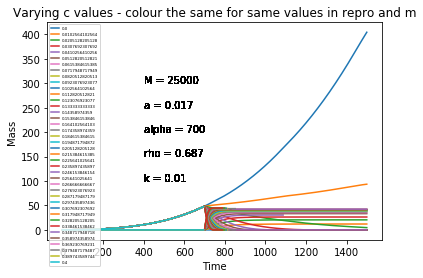

In [11]:
plt.figure()
ax = plt.gca()
# extra details to include in the graph as text
M_annotation  = "M = " + str(M)
a_annotation  = "a = " + str(a)
alpha_annotation  = "alpha = " + str(alpha)
rho_annotation  = "rho = " + str(rho)
k_annotation  = "k = " + str(k)

for i in mass.keys():
    # keep color the same for both growth curve and repro curve with same rho value
    color = next(ax._get_lines.prop_cycler)['color'] 
    plt.plot(t, mass[i], color = color, label = i)
    plt.plot(t, repro[i], color = color)
    # label for each value to be use in the legend
    plt.legend(loc = "upper left", prop={'size': 4})
    # formatting
    plt.xlabel("Time")
    plt.ylabel("Mass")
    plt.title("Varying c values - colour the same for same values in repro and m")
    # extra details for graph
    plt.text(400, 300, M_annotation) 
    plt.text(400, 250, a_annotation) 
    plt.text(400, 200, alpha_annotation) 
    plt.text(400, 150, rho_annotation) 
    plt.text(400, 100, k_annotation)
# save image
plt.savefig("../results/cFunc_exploration.png", dpi = 200)

## Notes
- `nan` produced from 0.3 and greater - range(0 - 3)
- `nan` produced from 0.2974... and greater - range(0 - 0.4) 
- `nan` produced from 0.194 and greater - manual investigation

- tiny increases in `a` give a lot of freedom for `c` to increase without producing `nan`

# Exploring $\kappa$ Values

## Code

In [12]:
## imports
import scipy as sc
from scipy import integrate

days = 1500 # time to simulate over

# define starting parameters -- using cod values from west 2001 as a base/ballpark values

m0 = 0.1 # starting mass at t_0
R0 = 0 # starting reproduction at t_0, 0 because organism not yet mature in my sims
a = 0.017 # cost of new mass 
b = 0 ## no need to calculate right now since i do it in function,could be done here to save time
c = 0.017 # reproductive cost 
M = 25000
alpha = 700 # age of maturation (days) | placeholder for this exploration
rho = .687 # reproductive scaling parameter 
k = 0.01

# define rho values to interate over
k_Vals = sc.linspace(0, 1, 20) 

# define vars to hold the output for each rho value
mass = dict()
repro = dict()



# organising starting params for use

mR0 = sc.array([m0, R0]) # starting values for integration, [starting mass, starting repro]
t = sc.arange(0, days, 1) # t values for integration
params = (alpha, M, a, c, rho, k) # tuple for integration arguments |need to specify in loop because of changig values


# integration
for k in k_Vals:
    mR = integrate.odeint(dRmdt, mR0, t, args = (alpha, M, a, c, rho, k))
    mass[str(k)] = mR[:, 0]
    repro[str(k)] = mR[:, 1]

# exploring output
len(mass.keys())

20

## Plots

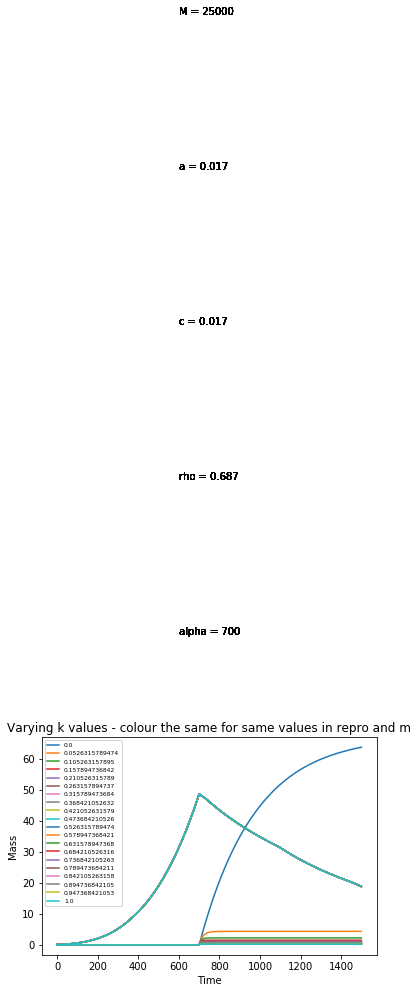

In [13]:
plt.figure()
ax = plt.gca()
# extra details to include in the graph as text
M_annotation  = "M = " + str(M)
a_annotation  = "a = " + str(a)
c_annotation  = "c = " + str(c)
rho_annotation  = "rho = " + str(rho)
alpha_annotation  = "alpha = " + str(alpha)

for i in mass.keys():
    # keep color the same for both growth curve and repro curve with same rho value
    color = next(ax._get_lines.prop_cycler)['color'] 
    plt.plot(t, mass[i], color = color, label = i)
    plt.plot(t, repro[i], color = color)
    # label for each value to be use in the legend
    plt.legend(loc = "upper left", prop={'size': 6})
    # formatting
    plt.xlabel("Time")
    plt.ylabel("Mass")
    plt.title("Varying k values - colour the same for same values in repro and m")
    # extra details for graph about the fixed values used for the simulation
    plt.text(600, 300, M_annotation) 
    plt.text(600, 250, a_annotation) 
    plt.text(600, 200, c_annotation) 
    plt.text(600, 150, rho_annotation) 
    plt.text(600, 100, alpha_annotation)
# save image
plt.savefig("../results/kappaFunc_exploration.png", dpi = 200)

# Exploring Supply / $a$ Exponents

## Modified Function

In [14]:
from scipy import exp 
def dRmdt2(mR0, t, alpha = 50, M = 1000, a = 2.15, c = 0.17, rho = 0.06, k = 0.01, x = 0.75): 
    """
    A function to simulate change in mass and reproductive output for a time point.  
    Function designed with the intention of beign integrated.
    
        Arguments:
        t {float} -- time
        mR0 {float} -- array with mass (g) and reproduction at start of time step 
        alpha {float} -- asymtotic mass (g)
        M {float} -- asymptotic mass
        a {float} -- growth rate (UNITS?)
        b {float} -- maintenace cost per cell ## found in function
        c {float} -- reproductive cost (UNITS?)}
        rho {float} -- scaling factor of reproduction (UNITS?)
        k
        Z {float} -- ## found in function
        
    Returns:
        {dict} -- 
            dmdt --rate of change of mass in grams^1/4 per day (g^1/4 d^-1) at time t
                NOTE:  integration of dmdt will give mass at t
            Rt -- reproductive output at time t in terms of mass 
                NOTE: integration of Rt gives total Reproductive output for the bounds of the integral
    """
    # predefine outputs 
                
    m = mR0[0] 
    R = mR0[1]
    b = a/(M**0.25)
    Z = 2/alpha
    Q = L(t-alpha, k)
    
    # conditional tree dependant on `alpha`
    if t < 0:
        return "ERROR: time < 0"
    if t < alpha:
        dmdt = (a * (m**x)) - (b * m)
        R = 0
    elif t >= alpha:
        
        dmdt = (a * (m**0.75)) - (b * m) - (c * (m**rho))
#         R = Q*c * m**rho
        R = (c * m**rho) * exp(-(k + Z) * (t - alpha))
    if m + dmdt < 0: # still not 100% sure why `-m`
        dmdt = -m
    
    return sc.array([dmdt, R])
#     return dict["dmdt" : dmdt, "Reproduciton" : R]

## Code

In [15]:
## imports
import scipy as sc
from scipy import integrate

days = 1500 # time to simulate over

# define starting parameters -- using cod values from west 2001 as a base/ballpark values

m0 = 0.1 # starting mass at t_0
R0 = 0 # starting reproduction at t_0, 0 because organism not yet mature in my sims
a = 0.017 # cost of new mass 
b = 0 ## no need to calculate right now since i do it in function,could be done here to save time
c = 0.017 # reproductive cost 
M = 25000
alpha = 700 # age of maturation (days) | placeholder for this exploration
rho = .687 # reproductive scaling parameter 
k = 0.01
x = 0.75 # exponent affecting supply
# define rho values to interate over
x_Vals = sc.linspace(0.75, 0.85, 50) 

# define vars to hold the output for each rho value
mass = dict()
repro = dict()



# organising starting params for use

mR0 = sc.array([m0, R0]) # starting values for integration, [starting mass, starting repro]
t = sc.arange(0, days, 1) # t values for integration
params = (alpha, M, a, c, rho, k, x) # tuple for integration arguments |need to specify in loop because of changig values


# integration
for x in x_Vals:
    mR = integrate.odeint(dRmdt2, mR0, t, args = (alpha, M, a, c, rho, k, x))
    mass[str(x)] = mR[:, 0]
    repro[str(x)] = mR[:, 1]

# exploring output
len(mass.keys())

50

## Plots

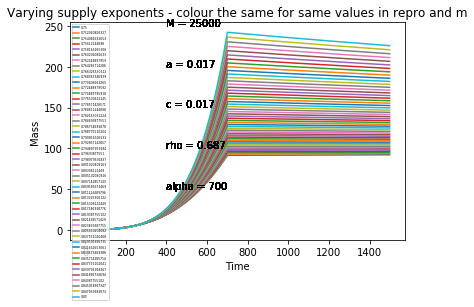

In [16]:
plt.figure()
ax = plt.gca()
# extra details to include in the graph as text
M_annotation  = "M = " + str(M)
a_annotation  = "a = " + str(a)
c_annotation  = "c = " + str(c)
rho_annotation  = "rho = " + str(rho)
alpha_annotation  = "alpha = " + str(alpha)
kappa_annotation  = "Kappa = " + str(k)
for i in mass.keys():
    # keep color the same for both growth curve and repro curve with same rho value
    color = next(ax._get_lines.prop_cycler)['color'] 
    plt.plot(t, mass[i], color = color, label = i)
#     plt.plot(t, repro[i], color = color)
    # label for each value to be use in the legend
    plt.legend(loc = "upper left", prop={'size': 3})
    # formatting
    plt.xlabel("Time")
    plt.ylabel("Mass")
    plt.title("Varying supply exponents - colour the same for same values in repro and m")
    # extra details for graph about the fixed values used for the simulation
    plt.text(400, 250, M_annotation) 
    plt.text(400, 200, a_annotation) 
    plt.text(400, 150, c_annotation) 
    plt.text(400, 100, rho_annotation) 
    plt.text(400, 50, alpha_annotation)
# save image
plt.savefig("../results/supplyFunc_exploration.png", dpi = 200)

## Notes

# General Notes:
# Factors affecting growth
- see kohler 1964![kohler 1964](notebook_images/kohler_1964.png)

- temperature is a big factor affecting growth rate within species (torno et al 2019)

# Messing

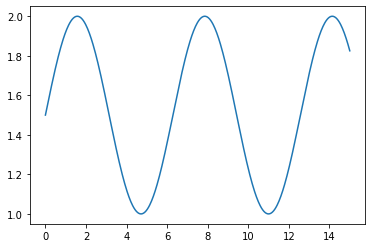

In [17]:
from scipy import sin
import scipy as sc
import matplotlib.pyplot as plt
def test(x, a = 1, b = 1, c = 1):
    return a * (b + (c * sc.sin(x)))

a = 1
line = sc.linspace(0, 15, 500)
days = sc.linspace(0, 500, 500)
var = []
for i, j in enumerate(line):
    var.append(test(j, b = 1.5,c = .5,))
#     var.append(FuncResp(Xr = i, a = 4, h = 1/a, q = 0))
#     var.append(FuncResp(Xr = a * (1+(0.5*sc.sin(j))), a = 4, h = 1/a, q = 0))
#     var.append(FuncResp(Xr = a * (1.5+(0.5*sc.sin(j)), a = 4, h = 1/a, q = 0))
#     for j in line:
#         var[round(i,2)] = test(i,j)

plt.figure()
plt.plot(line, var)
plt.show()
# max(var)
# min(var)
# enumerate(line)

In [18]:
round(line[2],2)


0.059999999999999998

In [19]:
round(4.5555,1)

4.6

[]

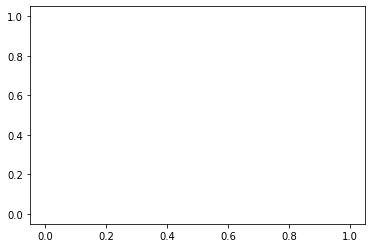

In [20]:
t = 733
if t > 365:
    t_temp = t - (365 * floor(t/365))
else:
    t_temp = t
x = t_temp/365 # as a percentage of the year to mimic a full year of seasonality
a = a * (1+(0.5*sc.sin(x)))
plt.figure()
plt.plot()

In [21]:
365*2

730